# INFO 5613 – Class 11: Network-level metrics

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Import libraries

In [1]:
# Load networkx for working with network data
import networkx as nx

# Load numpy for working with numerical data
import numpy as np

# Load pandas for working with tabular data
import pandas as pd

# Load visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb

import os
import random

# Define a formatting string we can use to print the number of nodes and edges
node_edge_s = "There are {0:,} nodes and {1:,} edges in the network"

### Helper functions

In [2]:
def visualize_network(g,k=1,weight='weight',labels=True,node_scale=300,font_size=8):
    # Create an empty canvas
    f,ax = plt.subplots(figsize=(10,10))

    # Compute node positions
    pos = nx.drawing.spring_layout(g,k=k,seed=42,iterations=100)

    # Calculate centralities
    centrality = nx.degree_centrality(g)

    # Draw the nodes, sized by centrality
    nx.draw_networkx_nodes(g,
                           pos=pos,
                           node_size=[v*node_scale for n,v in centrality.items()],
                           ax=ax
                          )

    # Draw the edges, sized by weight (number of scenes together)
    nx.draw_networkx_edges(g,
                           pos=pos,
                           alpha=.5,
                           width=[d[weight] for i,j,d in g.edges(data=True)],
                           ax=ax
                          )

    if labels:
    # Draw the node labels
        nx.draw_networkx_labels(g,
                                pos=pos,
                                font_size=font_size,
                                verticalalignment='bottom',
                                ax=ax
                               );
    
    return f,ax

In [3]:
def largest_component(g):
    _nodes = sorted(nx.components.connected_components(g),key=len,reverse=True)[0]
    return nx.subgraph(g,_nodes)

## Load data

### *Game of Thrones* character co-occurrences

In [4]:
# Load libraries
import json, requests
from itertools import combinations

# Get the data
got_episodes_json = requests.get('https://raw.githubusercontent.com/jeffreylancaster/game-of-thrones/master/data/episodes.json').json()

# Start with an empty undirected graph
got_graph_d = {}

# For each episode
for _e in got_episodes_json['episodes']:

    season_episode_str = "S{0:02d}E{1:02d}".format(_e['seasonNum'],_e['episodeNum'])
    
    _g = nx.Graph()
    
    # Get the scenes
    _scenes = _e['scenes']
    
    # For each scene
    for _s in _scenes:
        
        # Make the character combinations
        _combos = list(combinations([c['name'] for c in _s['characters']],2))
        
        # For each character combination
        for (char1,char2) in _combos:
            
            # Check if the character combination is already in the network
            if _g.has_edge(char1,char2):
                
                # If it is, increment the edge weight by 1
                _g[char1][char2]['weight'] += 1
                
            else:
                # If it is not, add the nodes and the edge with a weight of 1
                _g.add_edge(char1,char2,weight=1)
    
    got_graph_d[season_episode_str] = _g

In [5]:
# How many components in an episode of Game of Thrones?
nx.number_connected_components(got_graph_d['S02E01'])

7

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

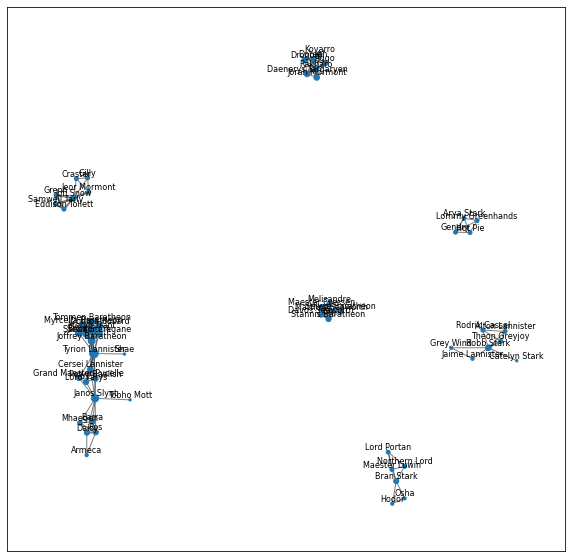

In [6]:
# Visualize to see the different components
visualize_network(got_graph_d['S02E01'],k=.3)

### Network science collaborations

Coauthorship network among network scientists from 2006.

In [7]:
netsci_g = nx.read_gml('netscience.gml')

print("There are {0:,} nodes and {1:,} edges.".format(netsci_g.number_of_nodes(),netsci_g.number_of_edges()))

There are 1,589 nodes and 2,742 edges.


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

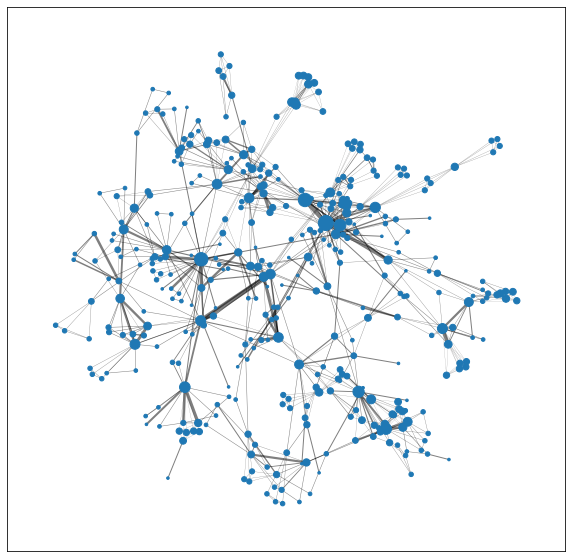

In [8]:
netsci_lcc = largest_component(netsci_g)
visualize_network(netsci_lcc,k=.25,weight='value',labels=False,node_scale=2500,font_size=7)

### IMDB actor collaborations 2000–2004

In [9]:
imdb_g = nx.read_gexf('actors_gt1.gexf')

print("There are {0:,} nodes and {1:,} edges.".format(imdb_g.number_of_nodes(),imdb_g.number_of_edges()))

There are 9,201 nodes and 80,373 edges.


## Components

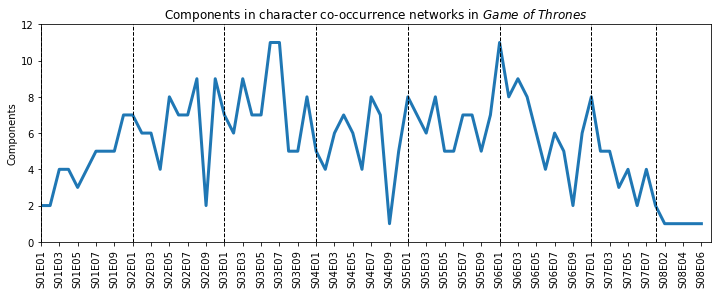

In [10]:
got_components = {}

for e,g in got_graph_d.items():
    got_components[e] = {}
    
    got_components[e]['components'] = len(list(nx.components.connected_components(g)))
    
component_df = pd.DataFrame(got_components).T

ax = component_df['components'].plot(lw=3,figsize=(12,4))

_labels = list(got_graph_d.keys())
ax.set_xticks(range(0,len(_labels),2))
ax.set_xticklabels(_labels[::2],rotation=90)

ax.set_xlim(0,len(_labels))
ax.set_ylim((0,12))
ax.set_ylabel('Components')
ax.set_title('Components in character co-occurrence networks in $\it{Game\ of\ Thrones}$')

for i,l in enumerate(_labels):
    if 'E01' in l:
        ax.axvline(i,ls='--',lw=1,c='k')

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

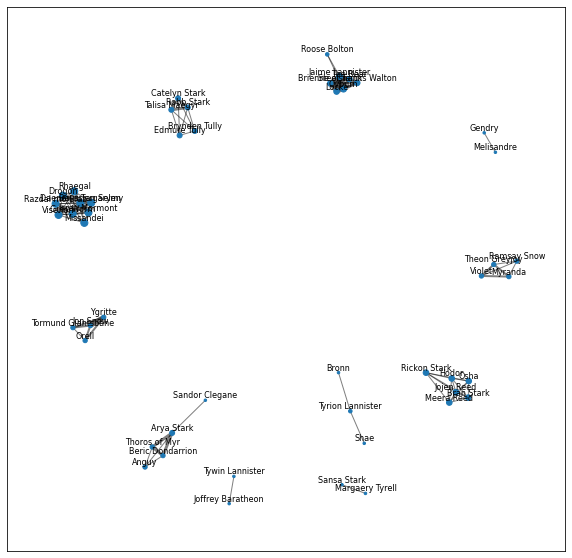

In [11]:
visualize_network(got_graph_d['S03E07'],k=.5)

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

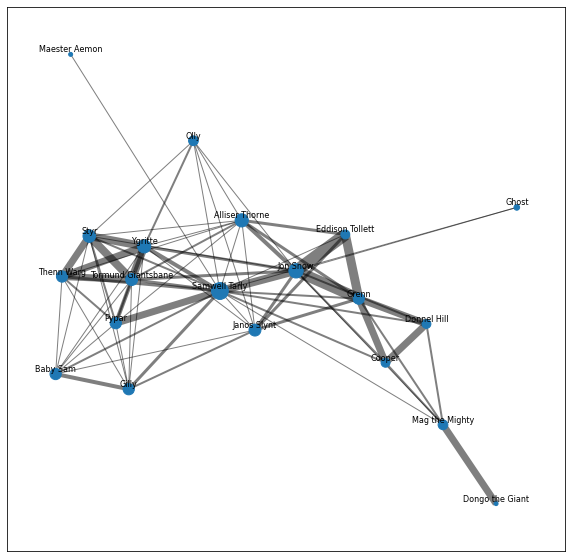

In [12]:
visualize_network(got_graph_d['S04E09'],k=2)

### Largest connected components

In [13]:
sorted(
    nx.components.connected_components(
        got_graph_d['S03E07']),
    key=len,
    reverse=True
)

[{'Barristan Selmy',
  'Daenerys Targaryen',
  'Drogon',
  'Grey Worm',
  'Jorah Mormont',
  'Missandei',
  'Razdal mo Eraz',
  'Rhaegal',
  'Viserion'},
 {'Brienne of Tarth',
  'Jaime Lannister',
  'Locke',
  'Qyburn',
  'Roose Bolton',
  'Steelshanks Walton',
  'The Bear'},
 {'Bran Stark', 'Hodor', 'Jojen Reed', 'Meera Reed', 'Osha', 'Rickon Stark'},
 {'Brynden Tully',
  'Catelyn Stark',
  'Edmure Tully',
  'Robb Stark',
  'Talisa Maegyr'},
 {'Anguy',
  'Arya Stark',
  'Beric Dondarrion',
  'Sandor Clegane',
  'Thoros of Myr'},
 {'Jon Snow', 'Orell', 'Tormund Giantsbane', 'Ygritte'},
 {'Myranda', 'Ramsay Snow', 'Theon Greyjoy', 'Violet'},
 {'Bronn', 'Shae', 'Tyrion Lannister'},
 {'Margaery Tyrell', 'Sansa Stark'},
 {'Joffrey Baratheon', 'Tywin Lannister'},
 {'Gendry', 'Melisandre'}]

In [14]:
len(largest_component(got_graph_d['S03E07']))/got_graph_d['S03E07'].number_of_nodes()

0.1836734693877551

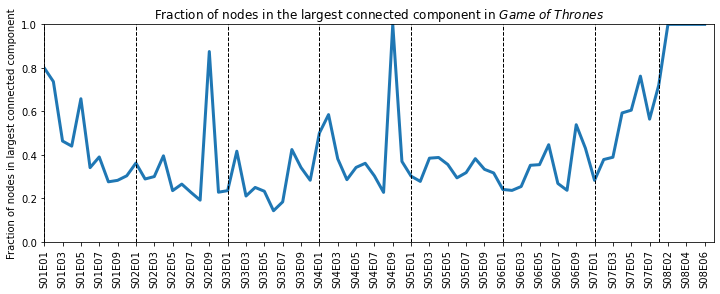

In [15]:
got_lcc = {}

for e,g in got_graph_d.items():
    got_lcc[e] = {}
    
    got_lcc[e]['lcc_fraction'] = len(largest_component(g))/g.number_of_nodes()
    
lcc_df = pd.DataFrame(got_lcc).T

ax = lcc_df['lcc_fraction'].plot(lw=3,figsize=(12,4))

_labels = list(got_graph_d.keys())
ax.set_xticks(range(0,len(_labels),2))
ax.set_xticklabels(_labels[::2],rotation=90)

ax.set_xlim(0,len(_labels))
ax.set_ylim((0,1))
ax.set_ylabel('Fraction of nodes in largest connected component')
ax.set_title('Fraction of nodes in the largest connected component in $\it{Game\ of\ Thrones}$')

for i,l in enumerate(_labels):
    if 'E01' in l:
        ax.axvline(i,ls='--',lw=1,c='k')

In the network science collaboration, 24% of nodes are in the largest component.

In [16]:
len(largest_component(netsci_g))/netsci_g.number_of_nodes()

0.23851478917558214

In the IMDB collaboration data, 96% of nodes are in the largest component.

In [17]:
len(largest_component(imdb_g))/imdb_g.number_of_nodes()

0.9569611998695794

## Small world phenomena

The average path length is: 12.88
The average clustering is: 0.500


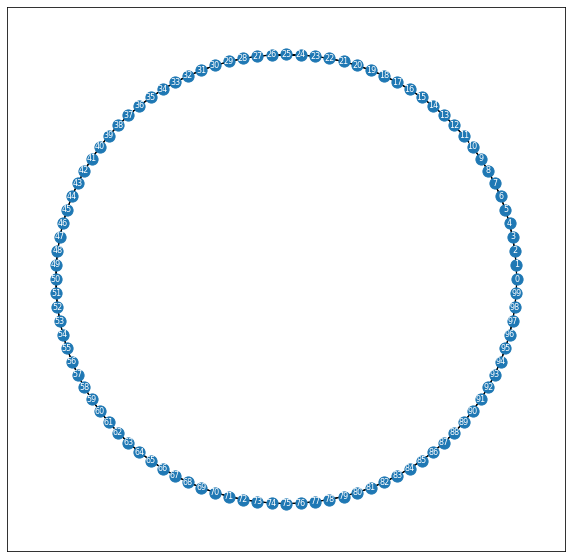

In [18]:
ws_0_g = nx.watts_strogatz_graph(
    n = 100,
    k = 5,
    p = 0,
    seed = 42
)

ws_0_g_path_length = nx.average_shortest_path_length(ws_0_g)
ws_0_g_clustering = nx.average_clustering(ws_0_g)

print("The average path length is: {0:.2f}\nThe average clustering is: {1:.3f}".format(ws_0_g_path_length,ws_0_g_clustering))

f,ax = plt.subplots(figsize=(10,10))

pos = nx.layout.circular_layout(ws_0_g)

nx.drawing.draw_networkx(
    ws_0_g,
    pos = pos,
    node_size = 125,
    font_size = 8,
    font_color = 'w',
    ax = ax
)

The average path length is: 7.44
The average clustering is: 0.479


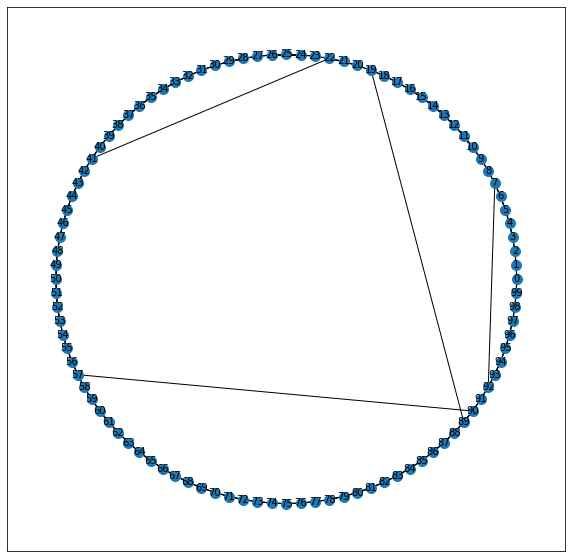

In [19]:
ws_01_g = nx.watts_strogatz_graph(
    n = 100,
    k = 5,
    p = .01,
    seed = 42
)

ws_01_g_path_length = nx.average_shortest_path_length(ws_01_g)
ws_01_g_clustering = nx.average_clustering(ws_01_g)

print("The average path length is: {0:.2f}\nThe average clustering is: {1:.3f}".format(ws_01_g_path_length,ws_01_g_clustering))

f,ax = plt.subplots(figsize=(10,10))

pos = nx.layout.circular_layout(ws_01_g)

nx.drawing.draw_networkx(
    ws_01_g,
    pos = pos,
    node_size = 100,
    font_size = 10,
    ax = ax
)

The average path length is: 4.91
The average clustering is: 0.383


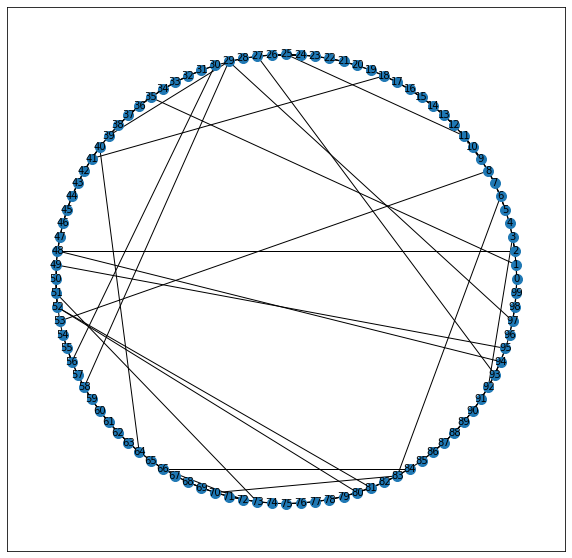

In [20]:
ws_1_g = nx.watts_strogatz_graph(
    n = 100,
    k = 5,
    p = .1,
    seed = 42
)

ws_1_g_path_length = nx.average_shortest_path_length(ws_1_g)
ws_1_g_clustering = nx.average_clustering(ws_1_g)

print("The average path length is: {0:.2f}\nThe average clustering is: {1:.3f}".format(ws_1_g_path_length,ws_1_g_clustering))

f,ax = plt.subplots(figsize=(10,10))

pos = nx.layout.circular_layout(ws_1_g)

nx.drawing.draw_networkx(
    ws_1_g,
    pos = pos,
    node_size = 100,
    font_size = 10,
    ax = ax
)

The average path length is: 3.63
The average clustering is: 0.097


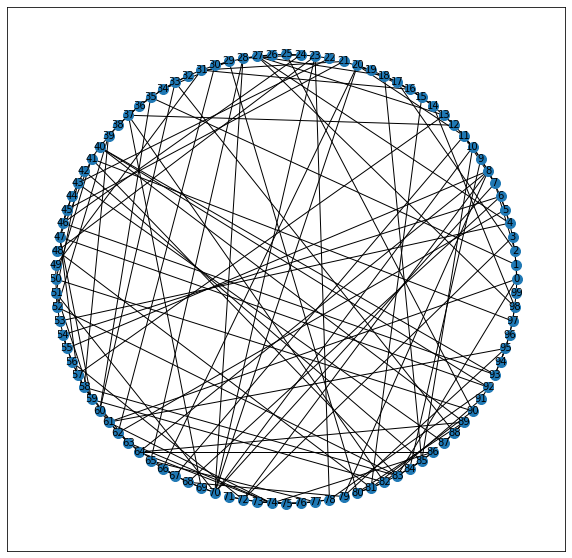

In [21]:
ws_5_g = nx.watts_strogatz_graph(
    n = 100,
    k = 5,
    p = .5,
    seed = 42
)

ws_5_g_path_length = nx.average_shortest_path_length(ws_5_g)
ws_5_g_clustering = nx.average_clustering(ws_5_g)

print("The average path length is: {0:.2f}\nThe average clustering is: {1:.3f}".format(ws_5_g_path_length,ws_5_g_clustering))

f,ax = plt.subplots(figsize=(10,10))

pos = nx.layout.circular_layout(ws_5_g)

nx.drawing.draw_networkx(
    ws_5_g,
    pos = pos,
    node_size = 100,
    font_size = 10,
    ax = ax
)

In [22]:
graph_stats = {}

lattice_g = nx.watts_strogatz_graph(
        n = 1000,
        k = 11,
        p = 0,
        seed = 42
    )

graph_stats[0] = {'Clustering':nx.average_clustering(lattice_g),
                   'Path Length':nx.average_shortest_path_length(lattice_g)
                  }

for _p in np.logspace(-4,0,25):
    _ws_g = nx.watts_strogatz_graph(
        n = 1000,
        k = 11,
        p = _p,
        seed = 42
    )
    
    graph_stats[_p] = {'Clustering':nx.average_clustering(_ws_g),
                       'Path Length':nx.average_shortest_path_length(_ws_g)
                      }

In [23]:
graph_stats_df = pd.DataFrame(graph_stats).T

graph_stats_df['C_norm'] = graph_stats_df['Clustering']/graph_stats_df.loc[0,'Clustering']
graph_stats_df['L_norm'] = graph_stats_df['Path Length']/graph_stats_df.loc[0,'Path Length']

graph_stats_df.head()

,Clustering,Path Length,C_norm,L_norm
0.000000,0.666667,50.450450,1.000000,1.000000
0.000100,0.666423,38.509814,0.999635,0.763320
0.000147,0.666423,38.509814,0.999635,0.763320
0.000215,0.666108,36.824847,0.999161,0.729921
0.000316,0.666108,36.824847,0.999161,0.729921


Text(0.5, 0, 'Fraction of nodes rewired')

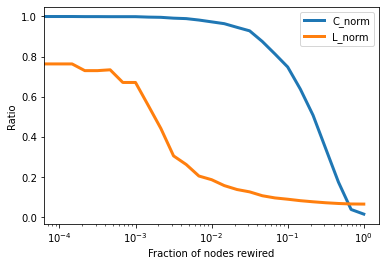

In [24]:
# Reproducing Figure 2 of Watts & Strogatz (1998)
ax = graph_stats_df[['C_norm','L_norm']].plot(lw=3)
ax.set_xscale('log')
ax.set_ylabel('Ratio')
ax.set_xlabel('Fraction of nodes rewired')

### Small world of Kevin Bacon

In [25]:
imdb_lcc = largest_component(imdb_g)

In [26]:
imdb_lcc.number_of_nodes(), imdb_lcc.number_of_edges()

(8805, 79300)

In [27]:
# Is Kevin Bacon in the network?
imdb_g.nodes['Bacon, Kevin']

{'label': 'Bacon, Kevin'}

Text(0.5, 1.0, 'Distribution of path lengths for Kevin Bacon')

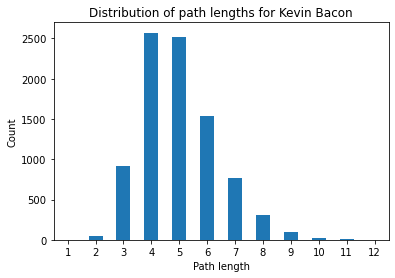

In [28]:
bacon_paths = nx.single_source_shortest_path(imdb_g, 'Bacon, Kevin')
bacon_path_lengths = pd.Series({n:len(l) for n,l in bacon_paths.items()})
bacon_path_lengths_hist = bacon_path_lengths.value_counts().sort_index()

ax = bacon_path_lengths_hist.plot.bar()
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_xlabel('Path length')
ax.set_ylabel('Count')
ax.set_title('Distribution of path lengths for Kevin Bacon')

In [29]:
bacon_path_lengths.mean()

5.0019307211811475

In [30]:
# Is Kevin Bacon the most well-connected node in the network?

pd.Series(nx.degree_centrality(imdb_g)).sort_values(ascending=True).head(20)

McCormack, Mary          0.000109
Lynch, Kelly (I)         0.000109
Bell, Kristen (I)        0.000109
Willing, Ute             0.000109
Parish, Sarah            0.000109
Shepherd, Steve John     0.000109
Ryan, Thomas Jay         0.000109
Krauss, Naomi            0.000109
McCoy, Matt              0.000109
Shepherd, Sherri         0.000109
Besançon, Nathalie       0.000109
Di Fonzo Bo, Marcial     0.000109
Russo, James (I)         0.000109
Riotta, Vincent          0.000109
Grieco, Richard (I)      0.000109
Franco, Jesus            0.000109
Howell, C. Thomas        0.000109
Plotnick, Jack           0.000109
Bostantzoglou, Yannis    0.000109
Léaud, Jean-Pierre       0.000109
dtype: float64

In [31]:
def path_length_hist(g,node):
    _paths = nx.single_source_shortest_path(imdb_g, node)
    _path_lengths = pd.Series({n:len(l) for n,l in _paths.items()})
    _path_lengths_hist = _path_lengths.value_counts().sort_index()

    f,ax = plt.subplots(figsize=(8,5))
    ax = _path_lengths_hist.plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    ax.set_xlabel('Path length')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of path lengths for {0}'.format(node))
    
    return f,ax

(<Figure size 576x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Distribution of path lengths for Streep, Meryl'}, xlabel='Path length', ylabel='Count'>)

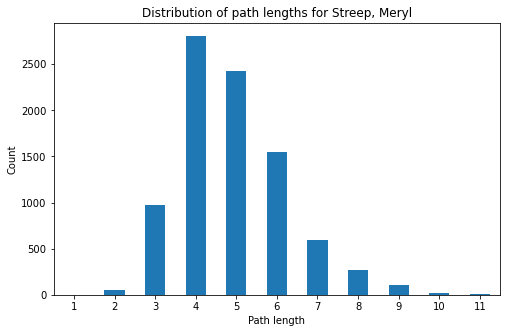

In [32]:
path_length_hist(imdb_g,'Streep, Meryl')

(<Figure size 576x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Distribution of path lengths for McCormack, Mary'}, xlabel='Path length', ylabel='Count'>)

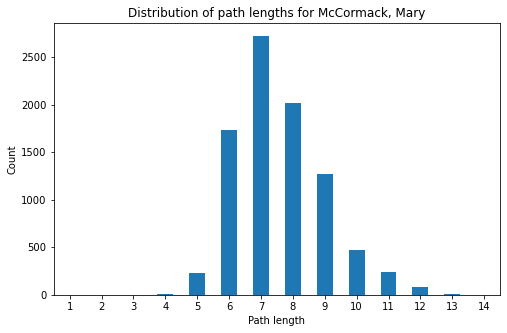

In [33]:
path_length_hist(imdb_g,'McCormack, Mary')

## Degree distributions

In [74]:
netsci_centrality_unnorm = {n:int(d*(len(netsci_g)-1)) for n,d in nx.degree_centrality(netsci_g).items()}

netsci_degree_hist = pd.Series(netsci_centrality_unnorm).value_counts().sort_index()

netsci_degree_hist

0     128
1     307
2     358
3     257
4     278
6      49
7      65
8      34
9      54
11      9
12     10
14      9
16      2
17      1
18      1
19     23
21      1
26      2
34      1
dtype: int64

Text(0, 0.5, 'Count')

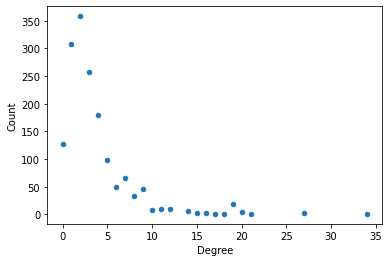

In [35]:
ax = netsci_degree_hist.reset_index().plot.scatter(x='index',y=0)
ax.set_xlabel('Degree')
ax.set_ylabel('Count')

(0.9, 1000.0)

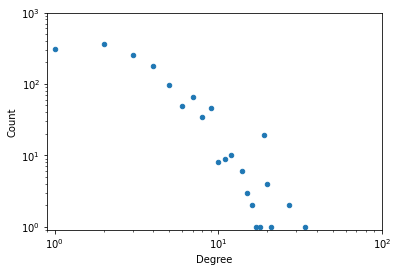

In [36]:
ax = netsci_degree_hist.reset_index().plot.scatter(x='index',y=0)
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((.9,1e2))
ax.set_ylim((.9,1e3))

Repeat for the IMDB collaboration.

In [37]:
imdb_centrality_norm = nx.degree_centrality(imdb_g)
imdb_centrality_unnorm = {n:int(d*(len(imdb_g)-1)) for n,d in imdb_centrality_norm.items()}

imdb_degree_hist = pd.Series(imdb_centrality_unnorm).value_counts().sort_index()

imdb_degree_hist

1      836
2      777
3      702
4      594
5      542
      ... 
263      1
265      1
291      1
295      1
306      1
Length: 182, dtype: int64

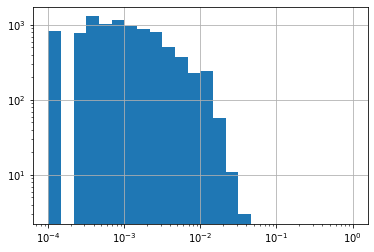

In [92]:
ax = pd.Series(imdb_centrality_norm).hist(bins=np.logspace(-4,0,25))
ax.set_yscale('log')
ax.set_xscale('log')

In [85]:
np.logspace(0,2,25,base=np.e)

array([1.        , 1.08690405, 1.18136041, 1.28402542, 1.39561243,
       1.5168968 , 1.64872127, 1.79200183, 1.94773404, 2.11700002,
       2.30097589, 2.50094001, 2.71828183, 2.95451153, 3.21127054,
       3.49034296, 3.79366789, 4.123353  , 4.48168907, 4.871166  ,
       5.29449005, 5.75460268, 6.25470095, 6.79825979, 7.3890561 ])

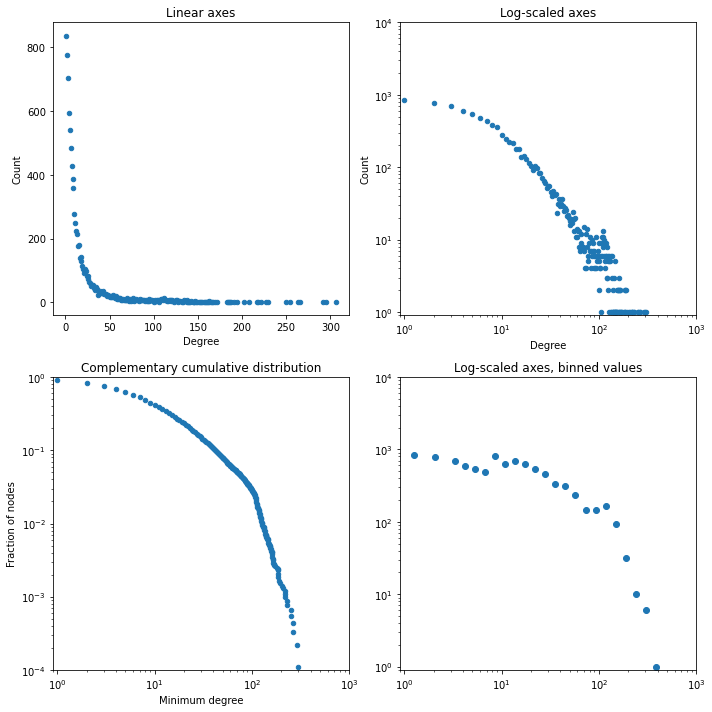

In [72]:
f,axs = plt.subplots(2,2,figsize=(10,10))

# Linear scale
imdb_degree_hist.reset_index().plot.scatter(x='index',y=0,ax=axs[0,0])
axs[0,0].set_xlabel('Degree')
axs[0,0].set_ylabel('Count')
axs[0,0].set_title('Linear axes')

# Log-scaled
imdb_degree_hist.reset_index().plot.scatter(x='index',y=0,ax=axs[0,1])
axs[0,1].set_xlabel('Degree')
axs[0,1].set_ylabel('Count')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlim((.9,1e3))
axs[0,1].set_ylim((.9,1e4))
axs[0,1].set_title('Log-scaled axes')

# Complementary cumulative distribution
imdf_ccdf = 1 - imdb_degree_hist.cumsum()/imdb_degree_hist.sum()
imdf_ccdf.reset_index().plot.scatter(x='index',y=0,ax=axs[1,0])
axs[1,0].set_xlabel('Minimum degree')
axs[1,0].set_ylabel('Fraction of nodes')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_xlim((.9,1e3))
axs[1,0].set_ylim((1e-4,1e0))
axs[1,0].set_title('Complementary cumulative distribution')

# Binning
imdb_counts,imdb_bins = np.histogram(list(imdb_centrality_unnorm.values()),bins=np.logspace(0,3,30))
axs[1,1].scatter(imdb_bins[1:],imdb_counts)
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_xlim((.9,1e3))
axs[1,1].set_ylim((.9,1e4))
axs[1,1].set_title('Log-scaled axes, binned values')

f.tight_layout()
f.set_facecolor('w')
f.savefig('imdb_degree_distribution.png',dpi=300)

Define some functions to help with curve-fitting.

In [53]:
from scipy.optimize import curve_fit

def fit_expon(x, a, b):
    return b * np.exp(-a * x)

def fit_lognorm(x, a, b, c):
    return b / (a * x * np.sqrt(2 * np.pi)) * np.exp(-c / 2 * (np.log(x)) ** 2)

def fit_powerlaw(x, a, b):
    return b * x ** (a)

def fit_trunc_powerlaw(x, a, b, c):
    return b * x ** (a) * np.exp(-x * c)

def fit_curved_powerlaw(x, a, b, c):
    return b * x ** (-a * x + c) 

def fit_expon_power(x, a, b, c, d):
    return b * x ** (a) * np.exp(1 + x ** c - np.exp(x ** d))

Use the data about the observed distribution to learn the best-fit parameters for each curve/model. Then use those curve parameters to predict what the degree distribution would be for each curve/model.

In [54]:
# Map the functions to labels
fit_func_d = {
    'Exponential':fit_expon,
    'Lognormal':fit_lognorm,
    'Power law':fit_powerlaw,
    'Truncated PL':fit_trunc_powerlaw,
    'Exponential power':fit_expon_power,
    'Curved PL':fit_curved_powerlaw
}

# Make a dictionary to park the predictions from each model
# Pre-populate with the observed data
fit_func_pred = {'Observed': imdb_degree_hist.values}

# For each function
for _func_name, _func in fit_func_d.items():
    
    # Learn the best parameters for fitting the curve to the data
    params,cov = curve_fit(_func,imdb_degree_hist.index,imdb_degree_hist.values)
    
    # Use the parameters on the function to make predictions
    fit_func_pred[_func_name] = _func(imdb_degree_hist.index, *params)
    
# Convert the observed data and predictions to a DataFrame
fit_df = pd.DataFrame(fit_func_pred,index=imdb_degree_hist.index).reset_index()

# Inspect
fit_df.head()

C:\Users\Brian\AppData\Local\Temp/ipykernel_29820/3256327985.py:4: RuntimeWarning: overflow encountered in exp
  return b * np.exp(-a * x)
C:\Users\Brian\AppData\Local\Temp/ipykernel_29820/3256327985.py:7: RuntimeWarning: overflow encountered in exp
  return b / (a * x * np.sqrt(2 * np.pi)) * np.exp(-c / 2 * (np.log(x)) ** 2)
C:\Users\Brian\AppData\Local\Temp/ipykernel_29820/3256327985.py:13: RuntimeWarning: overflow encountered in exp
  return b * x ** (a) * np.exp(-x * c)
C:\Users\Brian\AppData\Local\Temp/ipykernel_29820/3256327985.py:19: RuntimeWarning: overflow encountered in exp
  return b * x ** (a) * np.exp(1 + x ** c - np.exp(x ** d))


,index,Observed,Exponential,Lognormal,Power law,Truncated PL,Exponential power,Curved PL
0,1,836,838.735712,1259.708588,1134.655308,868.817806,850.628424,881.244393
1,2,777,751.954721,640.952794,671.415008,752.883441,772.009053,742.289767
2,3,702,674.152650,438.738300,493.962456,664.940630,682.302968,653.393164
3,4,594,604.400481,337.717760,397.299612,591.858941,601.571434,583.789241
4,5,542,541.865320,276.820724,335.551706,529.060970,531.590289,525.017843


Make three plots comparing the observed data against predictions. Top plot is on linear axes, middle plot is on logged axes, and bottom plot is on logged axes with binning.

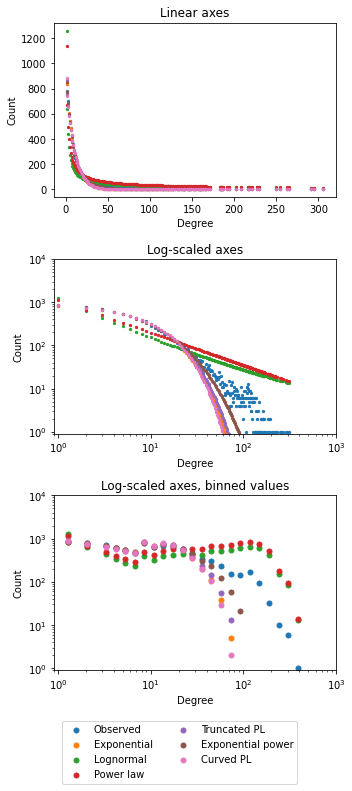

In [55]:
# Set up the plotting environment
f,axs = plt.subplots(3,1,figsize=(5,10))

# Plot the distributions for the top subplot
for i,_col in enumerate(fit_df.columns[1:]):
    fit_df.plot.scatter(
        x = 'index',
        y = _col,
        ax = axs[0],
        label = _col,
        c = list(mcolors.TABLEAU_COLORS.values())[i],
        legend = False,
        s = 5
    )

# Plot the distributions for the middle subplot
for i,_col in enumerate(fit_df.columns[1:]):
    fit_df.plot.scatter(
        x = 'index',
        y = _col,
        ax = axs[1],
        label = _col,
        c = list(mcolors.TABLEAU_COLORS.values())[i],
        legend = False,
        s = 5
    )

# Plot the distributions for the bottom subplot
for i,_col in enumerate(fit_df.columns[1:]):
    # Expand the counts back to the observations
    _vals = fit_df['index'].repeat(fit_df[_col]).values
    
    # Compute the log histogram over the observations
    _counts,_bins = np.histogram(_vals,bins=np.logspace(0,3,30))
    
    # Plot the log histogram
    axs[2].scatter(
        x = _bins[1:],
        y = _counts,
        c = list(mcolors.TABLEAU_COLORS.values())[i],
        s = 25,
        label = _col
    )
    
# Label the top subplot
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('Count')
axs[0].set_title('Linear axes')

# Put the middle subplot on log axes and label
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('Count')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((.9,1e3))
axs[1].set_ylim((.9,1e4))
axs[1].set_title('Log-scaled axes')

# Put the middle subplot on log axes and label
axs[2].set_xlabel('Degree')
axs[2].set_ylabel('Count')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim((.9,1e3))
axs[2].set_ylim((.9,1e4))
axs[2].set_title('Log-scaled axes, binned values')

# Make the legend
handles, labels = axs[2].get_legend_handles_labels()
f.legend(handles, labels, bbox_to_anchor = (.85,0),ncol=2)

# Clean up and write to disk
f.tight_layout()
f.set_facecolor('w')
f.savefig('imdb_degree_distribution_fits.png',dpi=300,bbox_inches='tight')

## Preferential attachment

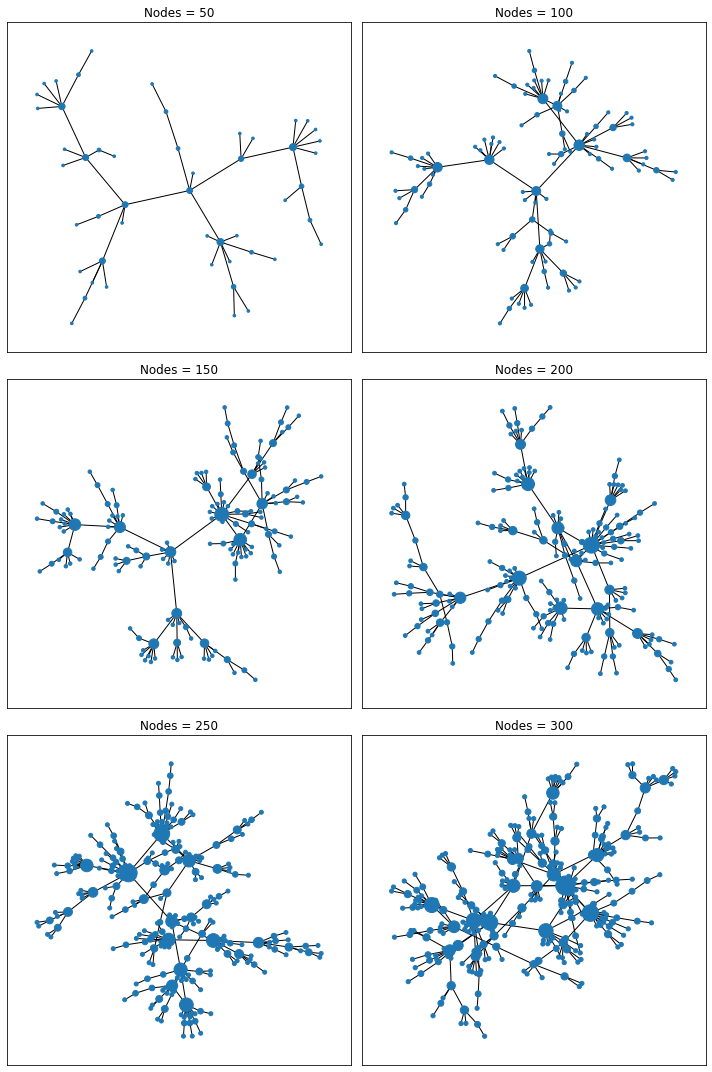

In [95]:
# Make an empty graph
pa_g = nx.Graph()

# Create a starting dyad
pa_g.add_edge(0,1)

# Index the number of nodes in the network
i = 2

f,axs = plt.subplots(3,2,figsize=(10,15))

# While there are fewer than N nodes
while i <= 300:
        
    # Compute the degree centralities
    pa_g_dc = nx.degree_centrality(pa_g)
    
    # Normalize the degree centralities
    probs = np.array(list(pa_g_dc.values()))
    probs /= probs.sum()
    
    # Choose a target node at random, weighted by its degree
    _targets = np.random.choice(pa_g.nodes(),size=1,replace=True,p=probs)
    
    # Create an edge between the new node and the target
    for _t in _targets:
        pa_g.add_edge(i,_t)
    
    # Increment the index
    i += 1
    
    if i % 50 == 0:
        pa_g_dc = nx.degree_centrality(pa_g) 
        _ax = axs.flatten()[int(i/50 - 1)]
        _ax.set_title('Nodes = {}'.format(i))
        nx.draw_networkx(
            pa_g,
            with_labels = False,
            node_size=[dc*(len(pa_g)-1)**1.5 for dc in pa_g_dc.values()],
            ax = _ax
        )
        
f.tight_layout()
f.set_facecolor('w')
f.savefig('pref_attach_2x3.png',dpi=300)

In [43]:
pa_g_dc = nx.degree_centrality(pa_g)

pa_g_counts = (pd.Series(pa_g_dc) * (len(pa_g) - 1)).value_counts().sort_index()
pa_g_counts

1.0     192
2.0      60
3.0      19
4.0      10
5.0       6
6.0       3
7.0       3
9.0       1
10.0      1
13.0      1
14.0      1
15.0      1
17.0      1
18.0      1
26.0      1
dtype: int64

(0.9, 1000.0)

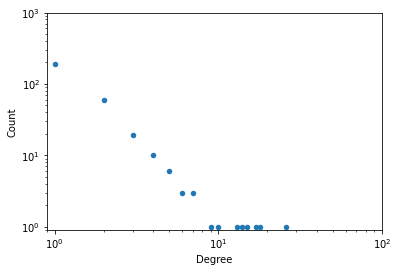

In [96]:
ax = pa_g_counts.reset_index().plot.scatter(x='index',y=0)
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((.9,1e2))
ax.set_ylim((.9,1e3))

In [45]:
# Diameter
nx.diameter(pa_g)

16

In [46]:
# Average shortest path
nx.average_shortest_path_length(pa_g)

6.2621040974529345

In [47]:
# Average clustering
nx.average_clustering(pa_g)

0.0

Text(0, 0.5, 'Neighbors with degree y')

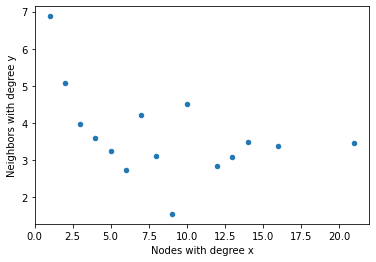

In [97]:
# Average neighbor degree
pa_g_neigh_conn = pd.Series(nx.average_degree_connectivity(pa_g)).sort_index()

ax = pa_g_neigh_conn.reset_index().plot.scatter(x='index',y=0)
ax.set_xlabel('Nodes with degree x')
ax.set_ylabel('Neighbors with degree y')

In [98]:
# Assortativity coefficient
nx.assortativity.degree_assortativity_coefficient(pa_g)

-0.20004421607751244

Text(0.5, 1.0, 'Earlier nodes get more connections')

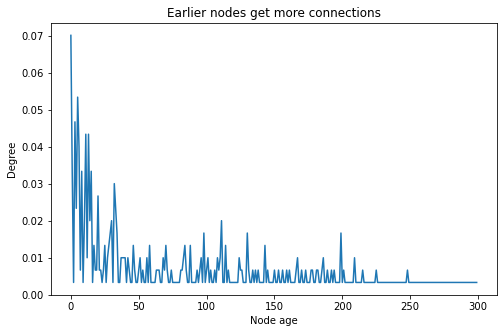

In [99]:
# Node IDs are added in order: smaller are added earlier
# Do earlier nodes have more connections?

ax = pd.Series(pa_g_dc).plot(figsize=(8,5))
ax.set_xlabel('Node age')
ax.set_ylabel('Degree')
ax.set_title('Earlier nodes get more connections')